# Processing for the Benchmark Data

In [1]:
import os
import sys
import feather
import warnings

import numpy as np # Numerical computing
import pandas as pd # Data manipulation

import seaborn as sns # R-like high-level plots
import matplotlib.pyplot as plt # Python's base plotting 

sys.path.append('../')
from src import utils, plots

warnings.filterwarnings('ignore')
# Initialize the timer
startTime = utils.getTime()

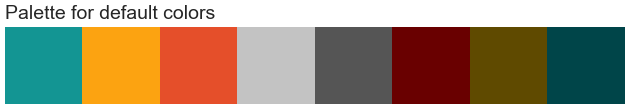

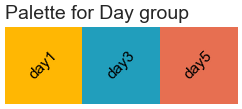

In [2]:
# Create a dictionary for a greyscale color palette with 9 colors
def_colors = [
    "#139593",
    "#fca311",
    "#e54f2a",
    "#c3c3c3",
    "#555555",
    "#690000",
    "#5f4a00",
    "#004549"
]

day_palette = {
    "day1": "#ffb703",
    "day3": "#219ebc",
    "day5": "#e76f51",
}

# Set seaborn style
sns.set_theme(
    style="white",
    context="paper",
    palette=def_colors,
    font_scale=1,
    rc={
        "figure.figsize": (6, 4),
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
    }
)

# Figure Saving Settings
figure_formats = ["png", "pdf"]
save_to_folder = True
transparet_bg = True
figure_dpi = 300

## Configure dataframe displaying
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

plots.color_palette(
    def_colors, 
    save=False
)

plots.color_palette(
    day_palette, 
    name = "Day group",
    save=False
)

In [3]:
notebook_name = "2_processing"
data_path = "./data/prepared/"
output_path = f"./data/processed/"
figure_path = f"./figures/{notebook_name}/"

# Create the output folder if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Create figure folder structure, if needed
if save_to_folder:
    for i in figure_formats:
        cur_folder = figure_path + i + "/"
        if not os.path.exists(cur_folder):
            os.makedirs(cur_folder)

## Functions

## Load Data

### Peptide Level

In [4]:
data = feather.read_dataframe(f"{data_path}SW_Benchmark_PeptideData.feather")
info_data = data.iloc[:, :12]
# info_data = info_data.set_index("Protein")
quan_data = data.iloc[:, 12:]

# Set the values lower than 8 (lloq) to NaN
quan_data[quan_data <= 8] = np.nan

quan_data = pd.concat([info_data.iloc[:, :2], quan_data], axis=1)
quan_data = quan_data.set_index(["Protein", "Mod.Peptide"])

print("Number of unique proteins:", info_data["Protein"].nunique())
print("Number of unique peptides:", info_data.shape[0])
print()
utils.print_shape(info_data, "Info")
utils.print_shape(quan_data, "Quant")

feather.write_dataframe(info_data, f"{output_path}info_data.feather")
info_data.head()

Number of unique proteins: 1829
Number of unique peptides: 20663

Info data has 20,663 rows and 12 columns
Quant data has 20,663 rows and 21 columns


,Protein,Mod.Peptide,Peptide,entryName,geneName,molecularWeight_kDa,sequence,startpos,endpos,seqLength,trace,Cov%
0,A0AVT1,YVLGDTAMQK,YVLGDTAMQK,UBA6_HUMAN,UBA6,117968.5800,MEGSEPVAAHQGEEASCSSWGTGSTNKNLPIMSTASVEIDDALYSR...,49,59,1052,0,12.3574
1,A0AVT1,NLVLAGIK,NLVLAGIK,UBA6_HUMAN,UBA6,117968.5800,MEGSEPVAAHQGEEASCSSWGTGSTNKNLPIMSTASVEIDDALYSR...,79,87,1052,0,12.3574
2,A0AVT1,LETGQFLTFR,LETGQFLTFR,UBA6_HUMAN,UBA6,117968.5800,MEGSEPVAAHQGEEASCSSWGTGSTNKNLPIMSTASVEIDDALYSR...,239,249,1052,0,12.3574
3,A0AVT1,TVFFESLER,TVFFESLER,UBA6_HUMAN,UBA6,117968.5800,MEGSEPVAAHQGEEASCSSWGTGSTNKNLPIMSTASVEIDDALYSR...,296,305,1052,0,12.3574
4,A0AVT1,AC(UniMod:4)IGDTLC(UniMod:4)QK,ACIGDTLCQK,UBA6_HUMAN,UBA6,117968.5800,MEGSEPVAAHQGEEASCSSWGTGSTNKNLPIMSTASVEIDDALYSR...,448,458,1052,0,12.3574


### Metadata

In [5]:
metadata = pd.read_csv(f"{data_path}SW_Benchmark_Metadata.csv")

# Create dictionary of day:run
day_run_dict = {
    day: metadata[metadata['day'] == day]['run'].to_list()
    for day in metadata['day'].unique()
}

utils.print_shape(metadata, "Metadata")
metadata

Metadata data has 21 rows and 4 columns


,run,SampleId,day,replicate
0,S1_SW_day1,S1,day1,NaN
1,S1_SW_day3,S1,day3,NaN
2,S1_SW_day5,S1,day5,NaN
3,S2_SW_day1,S2,day1,NaN
4,S2_SW_day3,S2,day3,NaN
5,S2_SW_day5,S2,day5,NaN
6,S3_SW_day1,S3,day1,NaN
7,S3_SW_day3,S3,day3,NaN
8,S3_SW_day5,S3,day5,NaN
9,S4_SW_day1_rep1,S4,day1,rep1


# Manipulating Data for Benchmarking

## Median Centering

### Initial Look

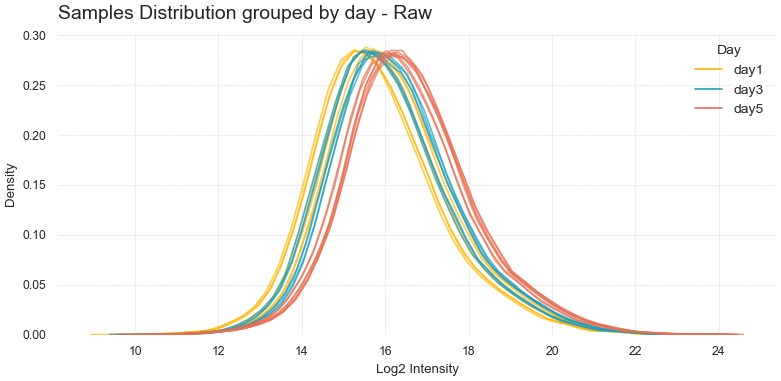

In [6]:
_ = plots.grouped_samples_density(
    data = quan_data, 
    group_sample_dict = day_run_dict,
    take_log2=True,
    color_dict=day_palette,
    title = "Samples Distribution grouped by day - Raw",
    legend_title = "Day",
    save=True,
    filename="Raw_DayGrouped_Density",
    filepath=figure_path,
    fileformats=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

### Median Centered Look

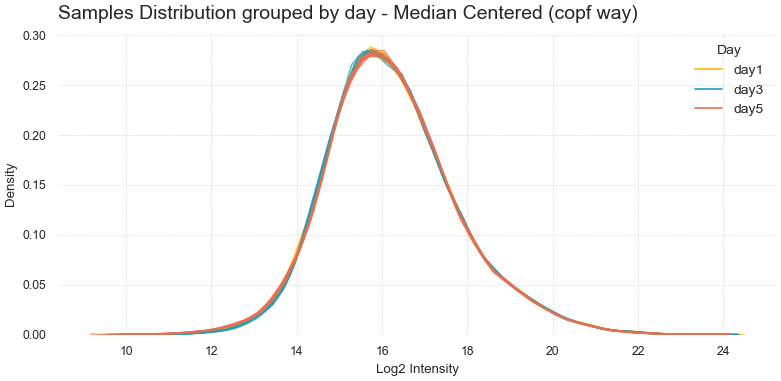

In [7]:
# Median Centered - Using data-wide median
centered_data = np.log2(quan_data).copy()
med_perSample = centered_data.median()
mean_median = med_perSample.mean()
diff_median = mean_median - med_perSample
# Add the difference to the data
centered_data = centered_data + diff_median
centered_data = 2**centered_data

_ = plots.grouped_samples_density(
    data = centered_data, 
    group_sample_dict = day_run_dict,
    take_log2=True,
    color_dict=day_palette,
    title = "Samples Distribution grouped by day - Median Centered (copf way)",
    legend_title = "Day",
    save=True,
    filename="MedianCentered1_DayGrouped_Density",
    filepath=figure_path,
    fileformats=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

## Introducing Noise to the Data

### Additive Noise from Uniform Distribution

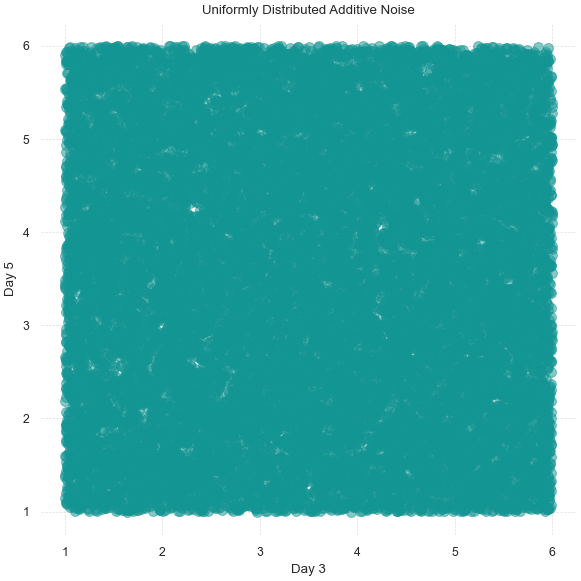

In [8]:
np.random.seed(1)
diff_in_d3 = np.random.uniform(1, 6, centered_data.shape[0])
np.random.seed(2)
diff_in_d5 = np.random.uniform(1, 6, centered_data.shape[0])

# Scatter plot two arrays
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(
    diff_in_d3, 
    diff_in_d5, 
    s=50, 
    alpha=0.5,
)
ax.set_title("Uniformly Distributed Additive Noise")
ax.set_xlabel("Day 3")
ax.set_ylabel("Day 5")
ax.grid(
    axis="both",
    which="major",
    color="lightgrey",
    linestyle="--",
    linewidth=.5,
    alpha=0.75,
)
sns.despine(
    left=True, 
    bottom=True
)
plt.tight_layout()

plots.save_figures(
    plt.gcf(),
    filename="UniformNoiseCheck_Scatter",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

### Add the Uniformly Distributed Noise to Day 3 and Day 5

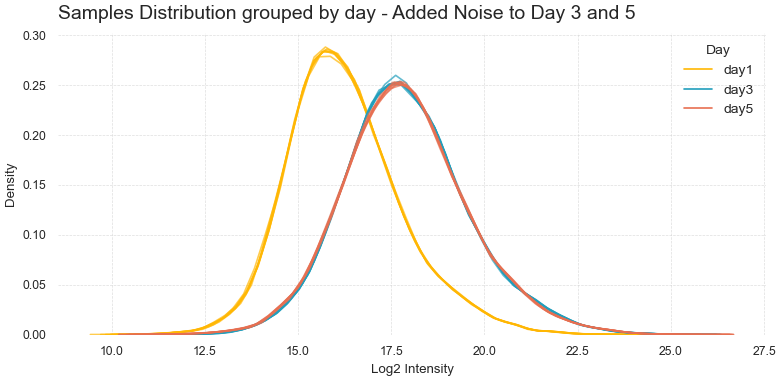

In [9]:
# Apply the noise to the data
noised_data = centered_data.copy()
noised_data.loc[:, day_run_dict["day3"]] = centered_data.loc[:, day_run_dict["day3"]].values * diff_in_d3.reshape(-1, 1)
noised_data.loc[:, day_run_dict["day5"]] = centered_data.loc[:, day_run_dict["day5"]].values * diff_in_d5.reshape(-1, 1)

_ = plots.grouped_samples_density(
    data = noised_data, 
    group_sample_dict = day_run_dict,
    take_log2=True,
    color_dict=day_palette,
    title = "Samples Distribution grouped by day - Added Noise to Day 3 and 5",
    legend_title = "Day",
    save=True,
    filename="Noised_DayGrouped_Density",
    filepath=figure_path,
    fileformats=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

## Add Perturbation to the Random Data

### Perturbation to Protein 

#### Randomly Select N Proteins to Perturb

In [10]:
# randomly select N proteins to perturb
np.random.seed(22)
nPerturbations = 1000
proteins = list(set(info_data["Protein"]))
perturbed_proteins = np.random.choice(proteins, nPerturbations, replace=False)
print(f"Number of proteins to perturb: {nPerturbations}")
print(f"Number of unique proteins: {len(proteins)}")
print(f"Number of unique perturbed proteins: {len(perturbed_proteins)}")

Number of proteins to perturb: 1000
Number of unique proteins: 1829
Number of unique perturbed proteins: 1000


#### Randomly Assign Reduction Factor for Each Perturbed Protein

Created random red factors for the perturbed proteins
Number of proteins in the dictionary: 1000


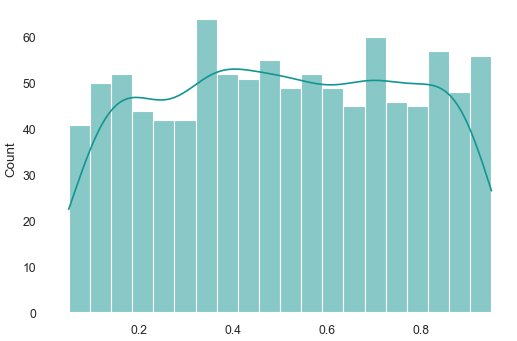

In [11]:
np.random.seed(44)
# python code (perturbed_proteins)
red_fac = np.random.uniform(0.05, 0.95, nPerturbations)
sns.histplot(red_fac, bins=20, kde=True)
sns.despine(left=True, bottom=True);

print("Created random red factors for the perturbed proteins")
protein_dict = dict(zip(perturbed_proteins, red_fac))
print(f"Number of proteins in the dictionary: {len(protein_dict)}")

In [12]:
# Get the noised data as long format
noised_data_long = noised_data.reset_index().melt(
    id_vars=["Protein", "Mod.Peptide"],
    var_name="Sample",
    value_name="Intensity"
)
noised_data_long['Condition'] = noised_data_long['Sample'].apply(lambda x: x.split("_")[2])
noised_data_long = noised_data_long[['Protein', 'Mod.Peptide', 'Sample', 'Condition', 'Intensity']]

noised_data_long

,Protein,Mod.Peptide,Sample,Condition,Intensity
0,A0AVT1,YVLGDTAMQK,S1_SW_day1,day1,38161.1894
1,A0AVT1,NLVLAGIK,S1_SW_day1,day1,55034.4666
2,A0AVT1,LETGQFLTFR,S1_SW_day1,day1,55501.6833
3,A0AVT1,TVFFESLER,S1_SW_day1,day1,89403.0386
4,A0AVT1,AC(UniMod:4)IGDTLC(UniMod:4)QK,S1_SW_day1,day1,35214.3468
...,...,...,...,...,...
433918,Q9Y6Y8,IDENYSLPTC(UniMod:4)K,S5_SW_day5,day5,82332.9919
433919,Q9Y6Y8,GFFNIYHPLDPVAYR,S5_SW_day5,day5,282346.8357
433920,Q9Y6Y8,SAWQTLNEFAR,S5_SW_day5,day5,166767.2275
433921,Q9Y6Y8,VVESPDFSKDEDYLGK,S5_SW_day5,day5,143047.9670


### Pertubation to Peptide+Protein

#### Function that can Used to Perturb the Data with Different Number of Perturbed Peptides per Protein

Perturbation scenario: random
Perturbed Data data has 433,923 rows and 17 columns


,Protein,Mod.Peptide,Sample,Condition,Intensity,geneName,seqLength,startpos,endpos,Cov%,trace,perturbed_protein,nPeps,nPerPeps,red_factor,perturbed_peptide,PerturbedIntensity
0,A0AVT1,YVLGDTAMQK,S1_SW_day1,day1,38161.1894,UBA6,1052,49,59,12.3574,0,True,13,3,0.6802,False,38161.1894
1,A0AVT1,NLVLAGIK,S1_SW_day1,day1,55034.4666,UBA6,1052,79,87,12.3574,0,True,13,3,0.6802,False,55034.4666
2,A0AVT1,LETGQFLTFR,S1_SW_day1,day1,55501.6833,UBA6,1052,239,249,12.3574,0,True,13,3,0.6802,True,55501.6833
3,A0AVT1,TVFFESLER,S1_SW_day1,day1,89403.0386,UBA6,1052,296,305,12.3574,0,True,13,3,0.6802,False,89403.0386
4,A0AVT1,AC(UniMod:4)IGDTLC(UniMod:4)QK,S1_SW_day1,day1,35214.3468,UBA6,1052,448,458,12.3574,0,True,13,3,0.6802,False,35214.3468


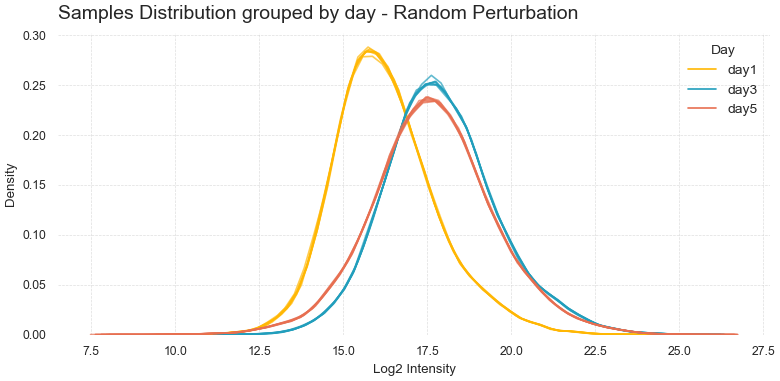

In [13]:
perturbScenario = "random"
print(f"Perturbation scenario: {perturbScenario}")

perturbed_data = utils.perturb_proteins(
    data = noised_data_long,
    info = info_data[["Protein", "Mod.Peptide", "geneName", "seqLength", "startpos", "endpos", "Cov%", "trace"]],
    proteinPertDict = protein_dict,
    perturbN = perturbScenario,
    proteinCol = "Protein",
    peptideCol = "Mod.Peptide",
    intensityCol = "Intensity",
    conditionCol = "Condition",
    condition2Perturb = "day5"
)

utils.print_shape(perturbed_data, "Perturbed Data")

plot_data = perturbed_data.pivot_table(
    index=["Protein", "Mod.Peptide"],
    columns="Sample",
    values="PerturbedIntensity"
)

_ = plots.grouped_samples_density(
    data = plot_data, 
    group_sample_dict = day_run_dict,
    take_log2=True,
    color_dict=day_palette,
    title = "Samples Distribution grouped by day - Random Perturbation",
    legend_title = "Day",
    save=True,
    filename="Perturbed_DayGrouped_Density",
    filepath=figure_path,
    fileformats=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

perturbed_data.head()

#### Visualize 5 Proteins with Perturbed Peptides

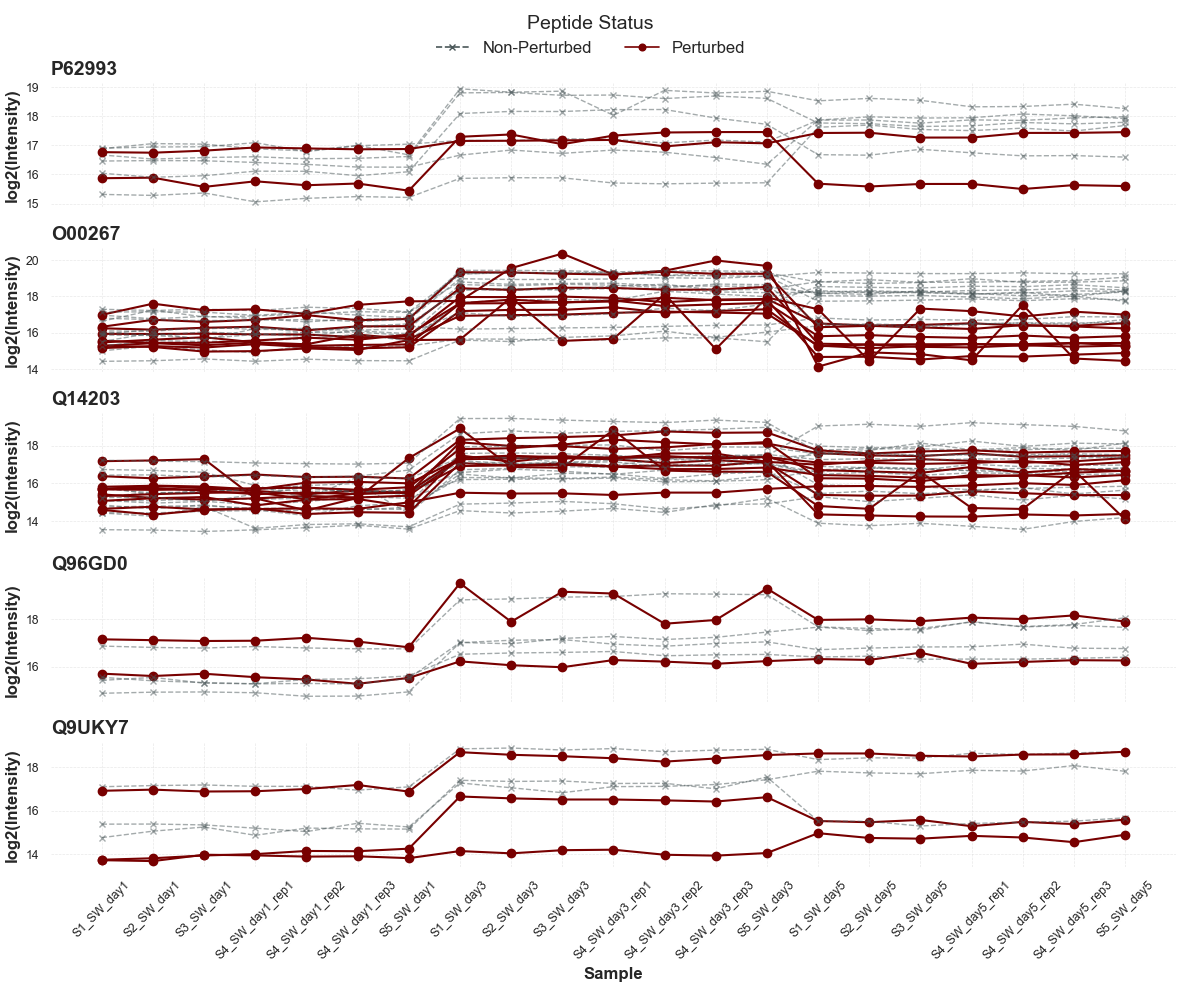

In [14]:
perturbed_data

nProtPlot = 5
ColOrder = metadata.sort_values(by=["day", "SampleId"])["run"].tolist() # Order of the columns
np.random.seed(2)
pertProtSubset = np.random.choice(list(protein_dict.keys()), nProtPlot, replace=False)

plot_data = perturbed_data[perturbed_data["Protein"].isin(pertProtSubset)]
plot_data["log2(Intensity)"] = np.log2(plot_data["PerturbedIntensity"])
# Reorder the columns
plot_data['Sample'] = pd.Categorical(
    plot_data['Sample'], 
    categories=ColOrder, 
    ordered=True
)

plot_data = plot_data.set_index("Protein")

# Create a figure with nProtPlot rows and plot lines
fig, ax = plt.subplots(nProtPlot, 1, figsize=(12, 2 * nProtPlot), sharex=True)

# Define the color palette once
palette = {False: "#4a5759", True: "#780000"}

for i, prot in enumerate(pertProtSubset):
    prot_data = plot_data.loc[prot]
    ax_i = ax[i] if nProtPlot > 1 else ax  # Handle case when nProtPlot is 1

    # Plot individual peptides as distinct lines with color if perturbed
    for pep in prot_data["Mod.Peptide"].unique():
        pep_data = prot_data[prot_data["Mod.Peptide"] == pep].sort_values("Sample")
        pert = pep_data["perturbed_peptide"].iloc[0]
        color = palette[pert]
        ax_i.plot(
            pep_data["Sample"],
            pep_data["log2(Intensity)"],
            label=pert if i == 0 else "",  # Only label the first plot for the legend
            color=color,
            marker='o' if pert else 'x',
            linestyle='-' if pert else '--',
            alpha=1 if pert else 0.5,
            linewidth=1.5 if pert else 1,
            markersize=6 if pert else 5,
        )

    ax_i.set_title(f"{prot}", fontsize=14, fontweight="bold", loc="left")
    if i == nProtPlot - 1: ax_i.set_xlabel("Sample", fontsize=12, fontweight="bold")
    ax_i.set_ylabel("log2(Intensity)", fontsize=12, fontweight="bold")
    ax_i.grid(axis="both", which="major", color="lightgrey", linestyle="--", linewidth=.5, alpha=0.5,)

# Last grids xtick rotation
plt.xticks(rotation=45)

# Manually create legend handles
handles = [
    plt.Line2D([0], [0], color=palette[False], marker='x', linestyle='--', label='Non-Perturbed'),
    plt.Line2D([0], [0], color=palette[True], marker='o', linestyle='-', label='Perturbed')
]

# Create a single legend at the top of the first subplot
fig.legend(handles=handles, loc='upper center', ncol=2, frameon=False, title="Peptide Status", fontsize=12, title_fontsize=14)
sns.despine(left=True, bottom=True)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the legend
plt.show()

# Creating Scenarios for Benchmarking 

All the scenarios are created with 1000 proteins randomly selected to perturb. The previous steps outlining the steps to get to the simulated data stays the same for all the scenarios. The only difference is the number of peptides that are perturbed for 1000 proteins.

1. Random Number of Peptide (up to 50%) Perturbation
2. Single Peptide Perturbation
3. Two Peptide Perturbation
4. Quarter of Peptides Perturbation
5. Half of Peptides Perturbation

## Creating the Data and Annotations for the Scenarios


In [15]:
# Line Plots Variables
np.random.seed(1)
print(f"The data contains:")
print(" Unique Proteins:", noised_data_long["Protein"].nunique())
print(" Unique Peptide:", noised_data_long["Mod.Peptide"].nunique()) 

The data contains:
 Unique Proteins: 1829
 Unique Peptide: 20663



### 1. Random Number of Peptide (up to 50%) Perturbation

In [16]:
# Scenario 1: Random perturbation
perturbScenario = "random"
savePath = f"{output_path}SW_Benchmark_{perturbScenario}N_PerturbedData.feather"
print(f"Creating Benchmark data for Perturbation scenario: {perturbScenario} number of peptides to perturb")

perturbed_data = utils.perturb_proteins(
    data = noised_data_long,
    info = info_data[["Protein", "Mod.Peptide", "geneName", "seqLength", "startpos", "endpos", "Cov%", "trace"]],
    proteinPertDict = protein_dict,
    perturbN = perturbScenario,
    proteinCol = "Protein",
    peptideCol = "Mod.Peptide",
    intensityCol = "Intensity",
    conditionCol = "Condition",
    condition2Perturb = "day5"
)

print()
print(
    "Perturbed data has", 
    perturbed_data[["Protein", "Mod.Peptide", "perturbed_peptide"]].drop_duplicates()["perturbed_peptide"].sum(), 
    "perturbed peptides"
)
print()
print("Saving the perturbed data to a feather file", savePath)
perturbed_data.to_feather(savePath)

Creating Benchmark data for Perturbation scenario: random number of peptides to perturb

Perturbed data has 3652 perturbed peptides

Saving the perturbed data to a feather file ./data/processed/SW_Benchmark_randomN_PerturbedData.feather


In [17]:
# Scenario 2: one peptide perturbation
perturbScenario = "one"
savePath = f"{output_path}SW_Benchmark_{perturbScenario}N_PerturbedData.feather"
print(f"Creating Benchmark data for Perturbation scenario: {perturbScenario} number of peptides to perturb")

perturbed_data = utils.perturb_proteins(
    data = noised_data_long,
    info = info_data[["Protein", "Mod.Peptide", "geneName", "seqLength", "startpos", "endpos", "Cov%", "trace"]],
    proteinPertDict = protein_dict,
    perturbN = perturbScenario,
    proteinCol = "Protein",
    peptideCol = "Mod.Peptide",
    intensityCol = "Intensity",
    conditionCol = "Condition",
    condition2Perturb = "day5"
)

print()
print(
    "Perturbed data has", 
    perturbed_data[["Protein", "Mod.Peptide", "perturbed_peptide"]].drop_duplicates()["perturbed_peptide"].sum(), 
    "perturbed peptides"
)
print()
print("Saving the perturbed data to a feather file", savePath)
perturbed_data.to_feather(savePath)

Creating Benchmark data for Perturbation scenario: one number of peptides to perturb

Perturbed data has 1000 perturbed peptides

Saving the perturbed data to a feather file ./data/processed/SW_Benchmark_oneN_PerturbedData.feather


In [18]:
# Scenario 3: two peptide perturbation
perturbScenario = "two"
savePath = f"{output_path}SW_Benchmark_{perturbScenario}N_PerturbedData.feather"
print(f"Creating Benchmark data for Perturbation scenario: {perturbScenario} number of peptides to perturb")

perturbed_data = utils.perturb_proteins(
    data = noised_data_long,
    info = info_data[["Protein", "Mod.Peptide", "geneName", "seqLength", "startpos", "endpos", "Cov%", "trace"]],
    proteinPertDict = protein_dict,
    perturbN = perturbScenario,
    proteinCol = "Protein",
    peptideCol = "Mod.Peptide",
    intensityCol = "Intensity",
    conditionCol = "Condition",
    condition2Perturb = "day5"
)

print()
print(
    "Perturbed data has", 
    perturbed_data[["Protein", "Mod.Peptide", "perturbed_peptide"]].drop_duplicates()["perturbed_peptide"].sum(), 
    "perturbed peptides"
)
print()
print("Saving the perturbed data to a feather file", savePath)
perturbed_data.to_feather(savePath)

Creating Benchmark data for Perturbation scenario: two number of peptides to perturb

Perturbed data has 2000 perturbed peptides

Saving the perturbed data to a feather file ./data/processed/SW_Benchmark_twoN_PerturbedData.feather


In [19]:
# Scenario 4: quarter of peptides perturbation
perturbScenario = "quarter"
savePath = f"{output_path}SW_Benchmark_{perturbScenario}N_PerturbedData.feather"
print(f"Creating Benchmark data for Perturbation scenario: {perturbScenario} number of peptides to perturb")

perturbed_data = utils.perturb_proteins(
    data = noised_data_long,
    info = info_data[["Protein", "Mod.Peptide", "geneName", "seqLength", "startpos", "endpos", "Cov%", "trace"]],
    proteinPertDict = protein_dict,
    perturbN = perturbScenario,
    proteinCol = "Protein",
    peptideCol = "Mod.Peptide",
    intensityCol = "Intensity",
    conditionCol = "Condition",
    condition2Perturb = "day5"
)

print()
print(
    "Perturbed data has", 
    perturbed_data[["Protein", "Mod.Peptide", "perturbed_peptide"]].drop_duplicates()["perturbed_peptide"].sum(), 
    "perturbed peptides"
)
print()
print("Saving the perturbed data to a feather file", savePath)
perturbed_data.to_feather(savePath)

Creating Benchmark data for Perturbation scenario: quarter number of peptides to perturb

Perturbed data has 2498 perturbed peptides

Saving the perturbed data to a feather file ./data/processed/SW_Benchmark_quarterN_PerturbedData.feather


In [20]:
# Scenario 5: half of peptides perturbation
perturbScenario = "half"
savePath = f"{output_path}SW_Benchmark_{perturbScenario}N_PerturbedData.feather"
print(f"Creating Benchmark data for Perturbation scenario: {perturbScenario} number of peptides to perturb")

perturbed_data = utils.perturb_proteins(
    data = noised_data_long,
    info = info_data[["Protein", "Mod.Peptide", "geneName", "seqLength", "startpos", "endpos", "Cov%", "trace"]],
    proteinPertDict = protein_dict,
    perturbN = perturbScenario,
    proteinCol = "Protein",
    peptideCol = "Mod.Peptide",
    intensityCol = "Intensity",
    conditionCol = "Condition",
    condition2Perturb = "day5"
)

print()
print(
    "Perturbed data has", 
    perturbed_data[["Protein", "Mod.Peptide", "perturbed_peptide"]].drop_duplicates()["perturbed_peptide"].sum(), 
    "perturbed peptides"
)
print()
print("Saving the perturbed data to a feather file", savePath)
perturbed_data.to_feather(savePath)

Creating Benchmark data for Perturbation scenario: half number of peptides to perturb

Perturbed data has 5506 perturbed peptides

Saving the perturbed data to a feather file ./data/processed/SW_Benchmark_halfN_PerturbedData.feather



# Conclude

In [21]:
print("Notebook Execution Time:", utils.prettyTimer(utils.getTime() - startTime))

Notebook Execution Time: 00h:00m:14s
